# Tutorial 1: part of the data will be trained and using $w(\phi) = \varphi$ to predict the fitness of new mutation combinations

If you didn't install dlim: !pip install dlim

dlim includes:
- DLIM: model 
- utils: for data and training 
- plot_figure: for plotting figures
- sim_data: simulate data points 


In [1]:
# Standard imports 
from torch import tensor, cat
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

# Load dlim model and data 
from dlim import DLIM
from dlim.utils import Data_model, train
from dlim.sim_data import Simulated

### Load the data 
for the simulated data, there are only 2 genes
- nb_state: specify how many possible mutations on each gene
- type_f: choose the landscape including "bio", "add", "quad", "saddle", "hat", "exp"

    1. bio: the mechanistic model from Kemble et all
    $$     F(X,Y) = \left ( w + \mu \varphi - \frac{\nu }{1/\eta - \varphi } \right )\left ( 1- \theta_X X - \theta_Y Y\right ) $$
    2. add: $$ F(X,Y) = X + Y$$
    3. quad: $$F(X,Y) = X*Y$$
    4. saddle: $$F(X,Y) = X^2 - Y^2$$
    5. hat: $$F(X,Y) = sin( X^2 + Y^2)$$
    6. exp: $$F(X,Y) = 10 \times (e^{-(2-X)^2 - (2-Y)^2})$$

You can also define yoru own functions by adding your function in dlim.sim_data package 


In [2]:
# choose the landscape: bio
type_f = "bio"
nb_state = 36
data = Simulated(nb_state, type_f)

### Define the model 
- nb_var = 2, because in the simulated data, there are two genes 
- nb_state: the number of possible mutations in each gene 
- hid: the number of neurons in the hidden layers 
- nb_layer: the number of hiden layers 

In [3]:

model = DLIM(nb_var=2, nb_state=nb_state, hid=32, nb_layer=1)

### Choose the data for training 


In [4]:
A_id = [i for i, el  in enumerate(data.A) if el >= 1.2]
B_id = [i for i, el  in enumerate(data.B) if el >= 1.2]
nA_id = [i for i, el  in enumerate(data.A) if i not in A_id]
nB_id = [i for i, el  in enumerate(data.B) if i not in B_id]
train_id = [i for i, el  in enumerate(data.data) if el[0] in A_id and el[1] in B_id]
train_data = data[train_id, :]
val_id = [i for i in range(data.data.shape[0]) if i not in train_id]
val_data = data[val_id, :]

### Visualization of the selected training data 
the black dots are the training sample, the whit dots are testing sample

/home/swang/miniconda3/envs/dlim_env/lib/python3.11/site-packages/dlim/sim_data.py:52: RuntimeWarning: divide by zero encountered in divide
  flux = lambda A, B: 1. / (1./A + 1./B + neta)


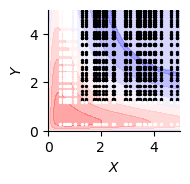

In [5]:
fig, ax = plt.subplots(1, figsize=(2, 2))
data.plot(ax)
ax.scatter(data.A[data.data[train_id, 0].long()], data.B[data.data[train_id, 1].long()], s=2, marker="o", c="black")
ax.scatter(data.A[data.data[val_id, 0].long()], data.B[data.data[val_id, 1].long()], s=2, marker="o", c="white")

for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
plt.tight_layout()
plt.show()

### train the model 
- the default optimizer is Adam
- lr: learning rate 
- nb_epoch: maximum epoch of optimization
- wei_dec: weight decay  
- bsize: batch size 

In [6]:
losses = train(model, train_data, lr=1e-2, nb_epoch=100, bsize=64, wei_dec=1e-1, val_data=val_data)


### Check the learning loss 


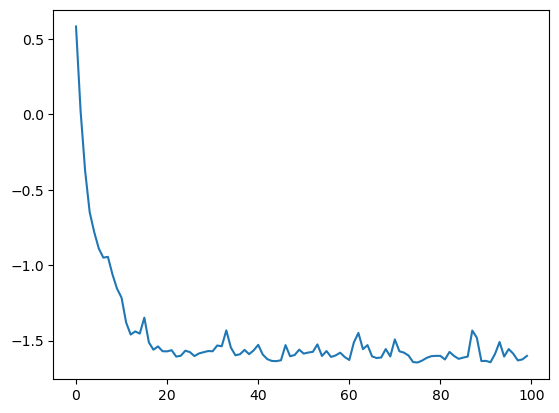

In [7]:
train_l, val_l = zip(*losses)
# plot the training and validation curve 
plt.plot(train_l)
plt.show()

### Get the predicted landscape 

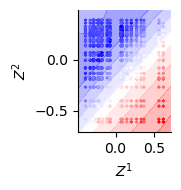

In [8]:
fig, bx = plt.subplots(1, figsize=(2, 2))
model.plot(bx)
bx.scatter(model.genes[0][data.data[train_id, 0].long()].detach(),
           model.genes[1][data.data[train_id, 1].long()].detach(),
           c=data.data[train_id, -1], s=2, cmap="bwr", marker="x")
for el in ["top", "right"]:
    bx.spines[el].set_visible(False)
# bx.set_aspect(1)
plt.tight_layout()
plt.show()

### Check fitting quality 

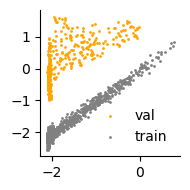

In [9]:
fit_no_exp, vari_no_exp, lat_no_exp = model(val_data[:, :-1].long(), detach=True)
fit_t, var_t, lat_t = model(train_data[:, :-1].long(), detach=True)

fig, ax = plt.subplots(1, figsize=(2, 2))
ax.scatter(fit_no_exp, val_data[:, [-1]], s=1, label="val", c="orange")
ax.scatter(fit_t, train_data[:, [-1]], s=1, label="train", c="grey")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

### Extrapolation by fitting the relationship between the estimated phenotype $\varphi$ and the measured phenotype $\phi$ 

In [10]:
# variable: indicate which gene allocated for the mutation 
model.train_convert(A_id, data.A[A_id], variable = 0)
model.train_convert(B_id, data.B[B_id], variable = 1)
model.update_emb(nA_id, data.A[nA_id], variable = 0)
model.update_emb(nB_id, data.B[nB_id], variable =1)

### Check the extrapolation on the variables 

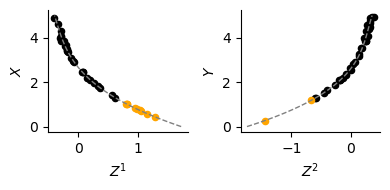

In [11]:
fig, (ax, bx) = plt.subplots(1, 2, figsize=(4, 2))
ax.scatter(model.genes[0][A_id].detach(), data.A[A_id], c="black", s=20)
ax.scatter(model.genes[0][nA_id].detach(), data.A[nA_id], c="orange", s=20)
# polynomial fitting 
ax.plot(np.polyval(model.conversion[0], np.linspace(0, 5, 100)), np.linspace(0, 5, 100), linewidth=1, linestyle="--", c="grey")
bx.scatter(model.genes[1][B_id].detach(), data.B[B_id], c="black", s=20)
bx.scatter(model.genes[1][nB_id].detach(), data.B[nB_id], c="orange", s=20)
bx.plot(np.polyval(model.conversion[1], np.linspace(0, 5, 100)), np.linspace(0, 5, 100), linewidth=1, linestyle="--", c="grey")
ax.set_ylabel("$X$")
ax.set_xlabel("$Z^1$")
bx.set_ylabel("$Y$")
bx.set_xlabel("$Z^2$")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
    bx.spines[el].set_visible(False)
plt.tight_layout()
plt.show()

### Compare the model with and without extrapolation 

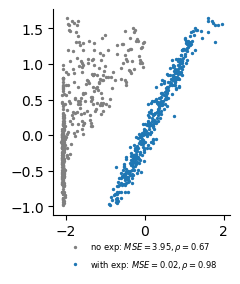

In [12]:
fit_with_exp, var_with_exp, lat_with_exp = model(val_data[:, :-1].long(), detach=True)
fig, ax = plt.subplots(1, figsize=(2.5, 3))
score_no_exp = ((fit_no_exp.flatten() - val_data[:, [-1]].flatten())**2).mean()
score_with_exp = ((fit_with_exp.flatten() - val_data[:, [-1]].flatten())**2).mean()

pearson_no_exp = pearsonr(fit_no_exp.flatten(), val_data[:, [-1]].flatten())[0]
pearson_with_exp = pearsonr(fit_with_exp.flatten(), val_data[:, [-1]].flatten())[0]
ax.scatter(fit_no_exp, val_data[:, [-1]], s=2, c="grey", label=r"no exp: $MSE={:.2f}, \rho = {:.2}$".format(score_no_exp,pearson_no_exp))
ax.scatter(fit_with_exp, val_data[:, [-1]], s=2, c="C0", label=r"with exp: $MSE={:.2f}, \rho = {:.2}$".format(score_with_exp,pearson_with_exp))

# ax.set_xlabel("$\\hat{F}$")
# ax.set_ylabel("$F^{obs}$")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
ax.legend(frameon=False, ncol=1, fontsize=6, loc='center', bbox_to_anchor=(0.5, -0.2))
plt.tight_layout()
plt.show()